# Function fitting with Constraints

## B.1 Fitting a standard GP

In [186]:
import matplotlib.pyplot as plt
import pyro.contrib.gp as gp
import pyro.distributions as dist
import pyro
import torch
from sklearn.model_selection import train_test_split
import seaborn as sns

plt.style.use("ggplot")
pyro.set_rng_seed(3317)

In [187]:
def g(x):
    return -(torch.sin(6.0 * torch.pi * x) ** 2) + 6 * x**2 - 5.0 * x**4 + 3.0 / 2.0

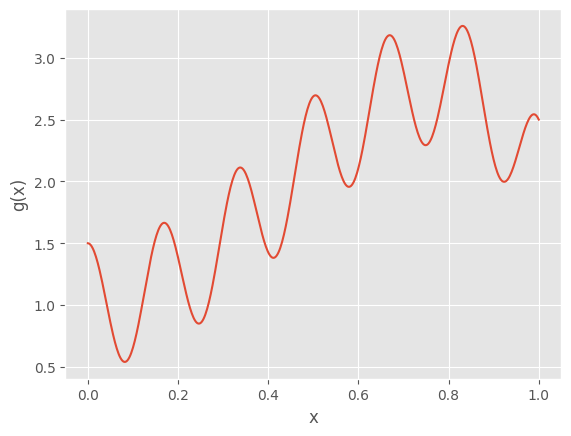

In [188]:
xs = torch.linspace(0, 1.0, 500)
ys = [g(x) for x in xs]

plt.plot(xs, ys)
plt.xlabel("x")
plt.ylabel("g(x)")
plt.show()

# Training and test data

We assume observations are given by:

$$
y_i = g(x_i) + \epsilon_i, \quad 
$$

where the observations are the grid $x_i = \frac{i-1}{l-1}, i=1,\ldots,l$ with $l=30$.

In [189]:
def generate_data(l=30, split=1.0 / 3.0):
    """
    Generate training and test data for the function g(x) = -(sin(6*pi*x)^2) + 6x^2 - 5x^4 + 3/2.
    :param l: Number of data points.
    :param split: Fraction of data to use as test data.
    :return: x_train, y_train, x_test, y_test
    """
    x = (torch.arange(1, l + 1) - 1) / (l - 1)
    y = g(x) + torch.sqrt(torch.tensor(0.01)) * torch.randn(len(x))

    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=split, random_state=3317
    )

    return x_train, y_train, x_test, y_test

In [190]:
x_train, y_train, x_test, y_test = generate_data()

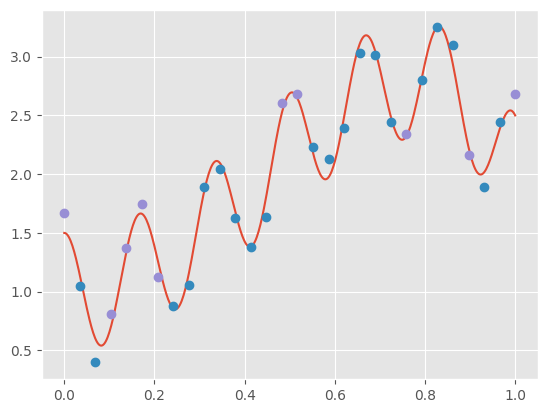

In [191]:
plt.plot(xs, ys)
plt.plot(x_train, y_train, "o", label="Training data")
plt.plot(x_test, y_test, "o", label="Test data")


## Setup Gaussian kernel

In [192]:
# refer to the "the kernel cookbook" for more information on kernels

# play around with the hyperparameters to see how they affect the model

rbf = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(1.0), lengthscale=torch.tensor(0.9)
)

# Choice of kernel:
# Data is periodic, so we use a periodic kernel
# Data is increasing, so we use a linear kernel
# Sum of kernels is also a kernel
# We use a sum of a linear and a periodic kernel
# The periodic kernel is due to David Mackey: Introduction to Gaussian Processes, eq. 47
# Kernel cookbook: https://www.cs.toronto.edu/~duvenaud/cookbook/

linear = gp.kernels.Linear(input_dim=1, variance=torch.tensor(2.0))

periodic = gp.kernels.Periodic(
    input_dim=1,
    period=torch.tensor(0.5),
    lengthscale=torch.tensor(1.0),
    variance=torch.tensor(2.0),
)

# sum of kernels is also a kernel
kernel = gp.kernels.Sum(kern0=linear, kern1=periodic)


## GP regression and plot prior samples

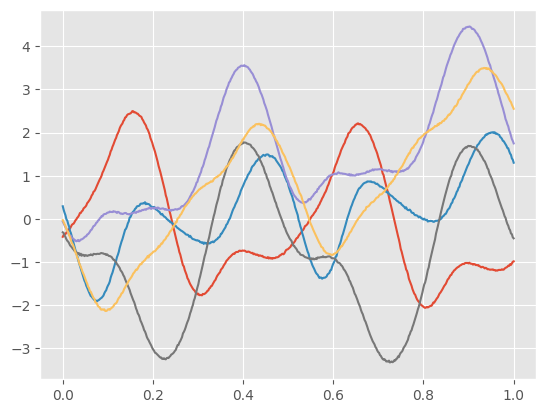

In [193]:
# ToDo should we add noise to the kernel?

pyro.clear_param_store()

# This is only regression, no tuning of hyperparameters
gpr = gp.models.GPRegression(x_train, y_train, kernel=kernel, noise=torch.tensor(0.01))

# Samples from the GP
n_samples = 5
n_points = 500
xs = torch.linspace(0.0, 1.0, n_points)
cov = kernel.forward(xs)  # + gpr.noise.expand(n_points).diag()
samples = dist.MultivariateNormal(
    torch.zeros(n_points),
    covariance_matrix=cov + torch.diag(torch.ones(n_points) * 0.0001),
).sample(sample_shape=(n_samples,))

for s in samples:
    plt.plot(xs, s)
# plt.savefig("./figures/b1_gp_samples.png")

## Plot GP regression (no tuning of hyperparameters)

This is just a sanity check to see if model is capable of matching data

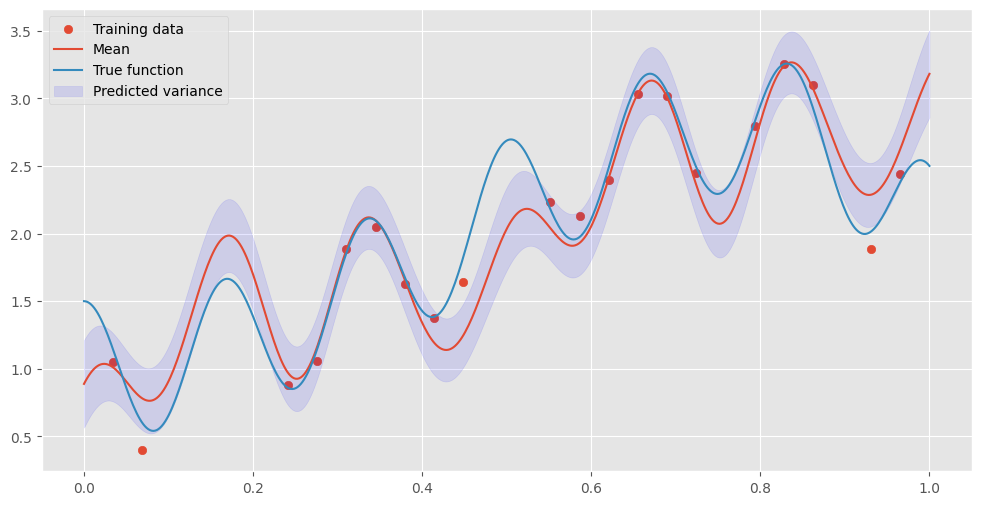

In [194]:
with torch.no_grad():
    mean, cov = gpr(xs, noiseless=False)

fig, ax = plt.subplots(figsize=(12, 6))

ax.scatter(x_train, y_train, label="Training data")
ax.plot(xs, mean, label="Mean")
ax.plot(xs, ys, label="True function")
ax.fill_between(
    xs,
    mean + torch.sqrt(cov) * 1.95,
    mean - torch.sqrt(cov) * 1.95,
    color="blue",
    alpha=0.1,
    label="Predicted variance",
)
plt.legend();

In [195]:
pyro.clear_param_store()
x_train, y_train, x_test, y_test = generate_data()

# Defining our kernels and GP-model
linear = gp.kernels.Linear(input_dim=1, variance=torch.tensor(2.0))

periodic = gp.kernels.Periodic(
    input_dim=1,
    period=torch.tensor(0.5),
    lengthscale=torch.tensor(1.0),
    variance=torch.tensor(1.0),
)
kernel = gp.kernels.Sum(kern0=linear, kern1=periodic)

gpr = gp.models.GPRegression(x_train, y_train, kernel=kernel, noise=torch.tensor(0.01))

# Putting priors on our kernel parameters
gpr.kernel.kern0.variance = pyro.nn.PyroSample(dist.HalfNormal(1.0))

gpr.kernel.kern1.period = pyro.nn.PyroSample(dist.Uniform(0.0, 1 / 6))
gpr.kernel.kern1.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
# gpr.kernel.kern1.variance = pyro.nn.PyroSample(dist.LogNormal(1.0, 1.0))
gpr.kernel.kern1.variance = pyro.nn.PyroSample(dist.HalfNormal(1.0))

gpr.noise = pyro.nn.PyroSample(dist.Gamma(1.0, 1.0))  # ToDo: why gamma?


# SVI with delta distribution as guide
optimizer = torch.optim.Adam(gpr.parameters(), lr=0.001)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
neg_likelihood_prior_joints = []
num_steps = 5000
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())


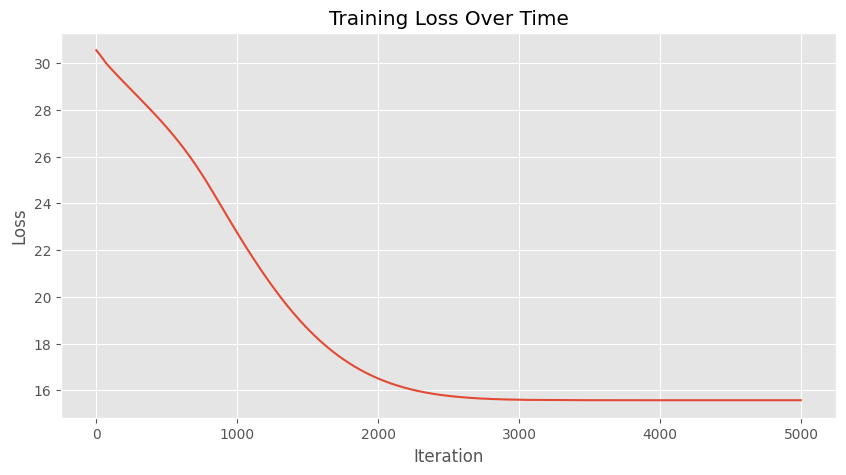

In [196]:
# Plot the loss
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x=range(len(losses)), y=losses, ax=ax)
ax.set_title("Training Loss Over Time")
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
plt.show()

In [197]:
# tell gpr that we want to get samples from guides
gpr.set_mode("guide")

kern1_variance = gpr.kernel.kern1.variance
kern1_lengthscale = gpr.kernel.kern1.lengthscale
kern1_period = gpr.kernel.kern1.period
noises = gpr.noise
kern0_variance = gpr.kernel.kern0.variance


print("variance = {}".format(gpr.kernel.kern1.variance))
print("lengthscale = {}".format(gpr.kernel.kern1.lengthscale))
print("period = {}".format(gpr.kernel.kern1.period))
print("variance = {}".format(gpr.kernel.kern0.variance))

print("noise = {}".format(gpr.noise))

variance = 0.6337969303131104
lengthscale = 0.9492635130882263
period = 0.08667248487472534
variance = 1.2356268167495728
noise = 0.07989797741174698


In [198]:
def evaluate(gp: pyro.contrib.gp.models.GPRegression, X_test, y_test):
    # Add a print statement before calling gp
    # print("Before calling gp" , X_test.shape)

    means, covs = gp(X_test, full_cov=True)
    # print("HEJ")
    # print(covs)
    # print("HEJ22")
    # Add a print statement after calling gp
    # print("After calling gp")

    log_likelihood = dist.MultivariateNormal(means, covs).log_prob(y_test)
    return log_likelihood

In [199]:
# Access the learned parameters (theta*) from the GP model
# theta_star = {
#     "period_map": pyro.param("period_map"),
#     "lengthscale_map": pyro.param("lengthscale_map"),
# }
# print("Learned Parameters (theta*):", {k: v.item() for k, v in theta_star.items()})

# # Evaluate the posterior log-likelihood of the test set on the fitted GP using θ*
# # Create the GP model using the MAP estimates
# print(theta_star["period_map"])
# print(["lengthscale_map"])
kernel = pyro.contrib.gp.kernels.Sum(
    pyro.contrib.gp.kernels.Periodic(
        input_dim=1,
        period=kern1_period,
        lengthscale=kern1_lengthscale,
        variance=kern1_variance,
    ),
    pyro.contrib.gp.kernels.Linear(input_dim=1, variance=kern0_variance),
)
gp = pyro.contrib.gp.models.GPRegression(
    x_train, y_train, kernel, noise=torch.tensor(0.01)
)
posterior_log_likelihood = evaluate(gp, x_test, x_test).item()
print("Posterior log-likelihood of the test set:", posterior_log_likelihood)

Posterior log-likelihood of the test set: -2179.955078125
